We are excited to find an open database that can let us run a project to predict the insurance costs.

## Plan

### Goal: 
1. To find out some potential insides through the insurance costs.
2. To build a machine learning model that can predict the medical costs billed by health insurance for future clients.

### About Dataset:

#### Context:
Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book.
#### Content:
Columns
* `age`: age of primary beneficiary
* `sex`: insurance contractor gender, female, male
* `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* `children`: Number of children covered by health insurance / Number of dependents
* `smoker`: Smoking
* `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* `charges`: Individual medical costs billed by health insurance
#### Acknowledgements:
The dataset is available on GitHub here: https://github.com/stedy/Machine-Learning-with-R-datasets
#### Inspiration:
Can you accurately predict insurance costs?

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import lightgbm as ltb
import xgboost as xgb
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

import warnings

warnings.filterwarnings("ignore")

In [2]:
medical_original = pd.read_csv(r"E:\data_folder\Medical Cost Personal Datasets\insurance.csv")

In [3]:
medical_original.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
medical_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are 1338 rows and 7 columns in this dataset. We see there is no missing value through the info function. It is actually a small dataset. In addition, `sex`, `smoker` and `region` are categorical variables.

In [5]:
medical_original[medical_original.duplicated(keep = False) == True]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


Jupyter Notebook considers the index 195 and 581 are duplicated values. After pulling up both of the indexes, we agree that there is a very little chance two different people have exactly the same age, sex, bmi, charges etc. In this case, we are going to drop the duplicated value.

In [6]:
df = medical_original.drop_duplicates()
df.reset_index(inplace = True)  # Create an index variable for EDA processes

## Analyze

### Overall

In [7]:
df.describe(include = 'all')

,index,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1337.000000,1337,1337.000000,1337.000000,1337,1337,1337.000000
unique,NaN,NaN,2,NaN,NaN,2,4,NaN
top,NaN,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,NaN,675,NaN,NaN,1063,364,NaN
mean,668.565445,39.222139,NaN,30.663452,1.095737,NaN,NaN,13279.121487
std,386.528803,14.044333,NaN,6.100468,1.205571,NaN,NaN,12110.359656
min,0.000000,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,334.000000,27.000000,NaN,26.290000,0.000000,NaN,NaN,4746.344000
50%,669.000000,39.000000,NaN,30.400000,1.000000,NaN,NaN,9386.161300
75%,1003.000000,51.000000,NaN,34.700000,2.000000,NaN,NaN,16657.717450


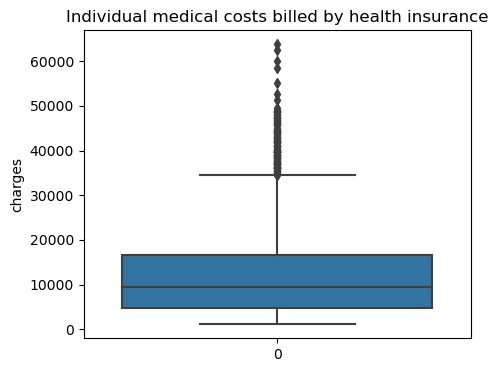

In [8]:
plt.figure(figsize=(5,4))
sns.boxplot(df['charges'])
plt.title("Individual medical costs billed by health insurance")
plt.ylabel('charges')
plt.show()

As we have seen in the description data, the `charge` has very large standard deviation, that is a sign that this variable contains outliers, we can see the above figure that proves what we just said: the medical bills more than approximately \\$38000 can be considered as outliers. But based on the medical insurance industry, it can still be normal. Plus we only have 1337 data in the dataset, it is not a good idea to drop all the outliers data. To make this issue impact less in our prediction, we can use tree-based models which are not sensitive about outliers later.

Let's pull up a pairplot and get ideas of the relationship between `charge` and each variable.

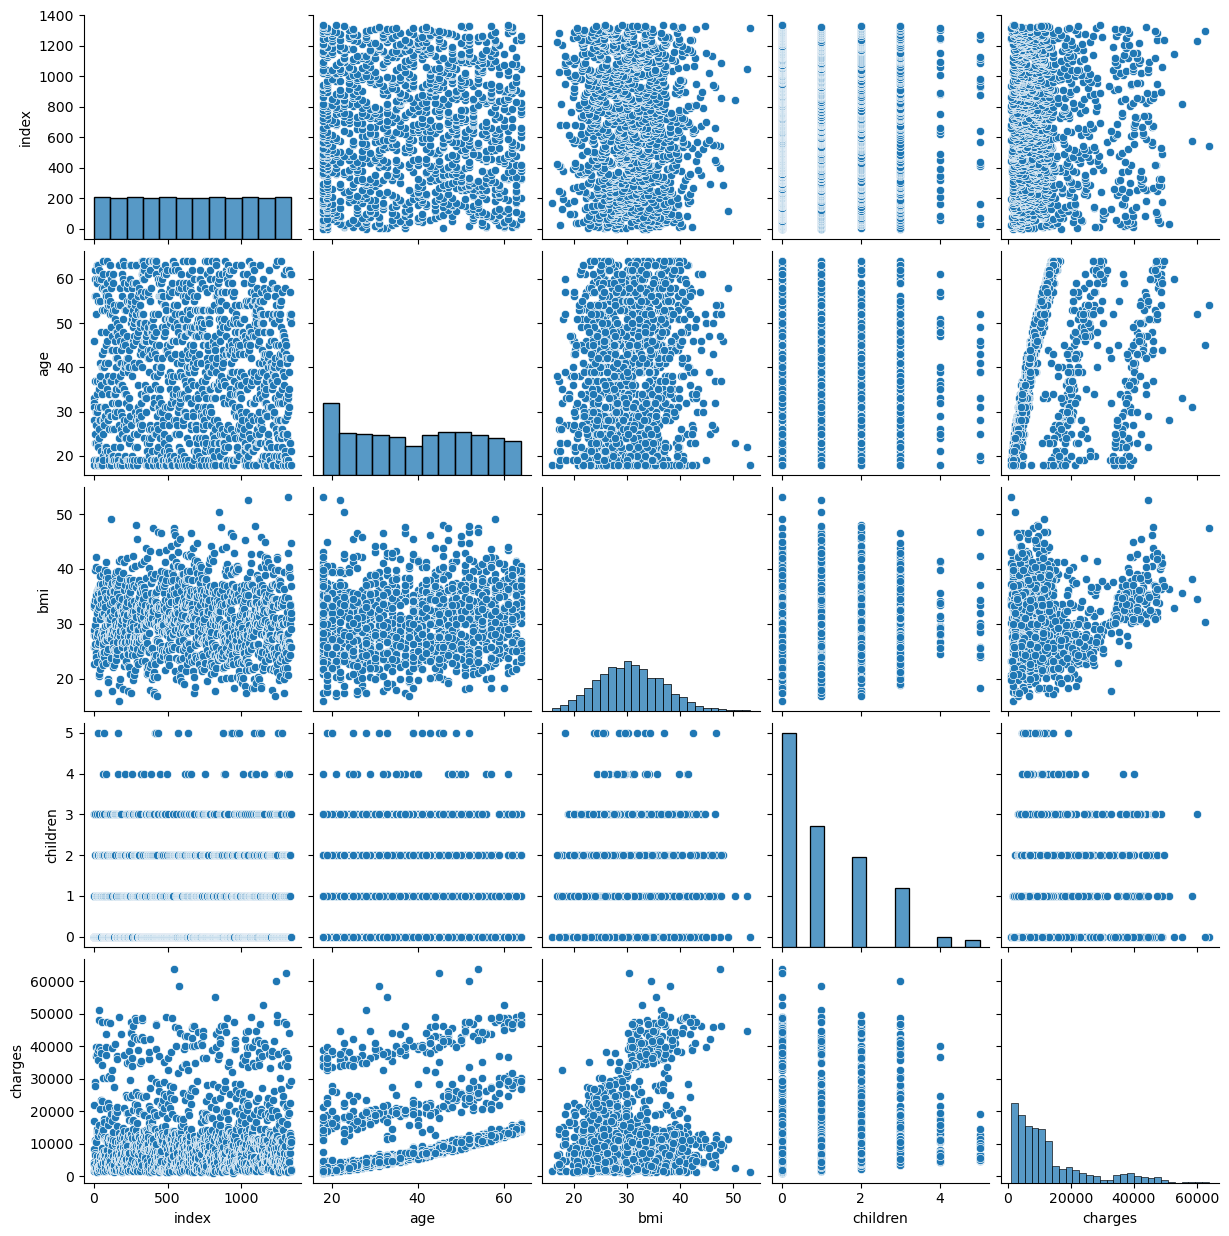

In [9]:
sns.pairplot(df)

In the pairplot, we can see `age` and `bmi` appear in some linear relationships with `charges`. Let's use more visualizations to find out more insights.

### Question: How is age and gender related to the medical cost?

Note:
<br>

We usually remove `sex`(or `gender`) for ethical reasons, as we don't want our model-making predictions based on a person's gender.

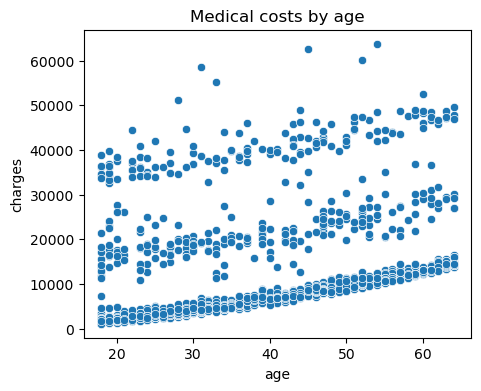

In [10]:
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='age', y='charges')
plt.title("Medical costs by age")
plt.show()

As we can see, whatever level of medical insurance the individuals have, when the individuals get older, the medical cost is increased. Let's add the gender into it.

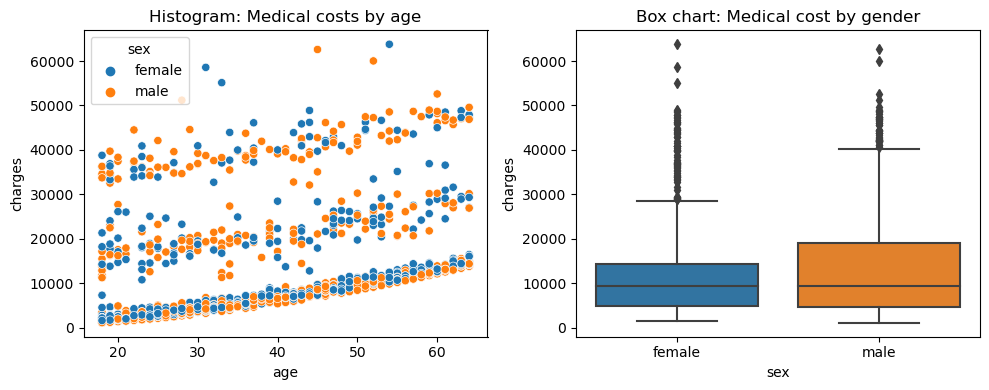

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (10,4))

sns.scatterplot(data=df, x='age', y='charges', hue="sex", ax=axes[0])
axes[0].set_title("Histogram: Medical costs by age")

sns.boxplot(data=df, x='sex', y='charges', ax=axes[1])
axes[1].set_title("Box chart: Medical cost by gender")

plt.tight_layout()
plt.show()

Some insights we have found out here:
* We can see there are 7 individuals who have medical bills more than \\$50000 (see table "Table: Medical bills more than \\$50000" below), their ages are between 28-60 which we consider as "adult". To think about the trend we just concluded "when the individuals get older, the medical cost is increased", we are wondering the reasons that make those adult individuals cost much more than others.
* The group in the middle in the scatter plot "Histogram: Medical costs by age", we see the cost is more discrete than the group in the bottom of the plot. We consider it is because of the following reasons: (1) This group of people have more health concerns (we will figure it out later), (2) When the individuals take medical facilities, different insurance companies have different charges.  
* The group in the top of the scatter plot, males are more than the females (see table "Table: Medical bills more than 30000 based on genders), it may be because the males are likely to have more health concerns than the females.

In [12]:
# Table: Medical bills more than 50000

df[df['charges']>50000]

,index,age,sex,bmi,children,smoker,region,charges
34,34,28,male,36.400,1,yes,southwest,51194.55914
543,543,54,female,47.410,0,yes,southeast,63770.42801
577,577,31,female,38.095,1,yes,northeast,58571.07448
818,819,33,female,35.530,0,yes,northwest,55135.40209
1145,1146,60,male,32.800,0,yes,southwest,52590.82939
1229,1230,52,male,34.485,3,yes,northwest,60021.39897
1299,1300,45,male,30.360,0,yes,southeast,62592.87309


In [13]:
# Table: Medical bills more than 30000 based on genders

df[df['charges']>30000].groupby(['sex'])['index'].count().reset_index()

,sex,index
0,female,59
1,male,103


### Question: How is BMI related to the medical cost?

According to Wikipedia: Body mass index is a value derived from the mass and height of a person. The BMI is defined as the body mass divided by the square of the body height, and is expressed in units of kg/m², resulting from mass in kilograms and height in metres. 
<br>

The BMI is a convenient rule of thumb used to broadly categorize a person as underweight, normal weight, overweight, or obese based on tissue mass (muscle, fat, and bone) and height. Major adult BMI classifications are underweight (under 18.5 kg/m2), normal weight (18.5 to 24.9), overweight (25 to 29.9), and obese (30 or more). When used to predict an individual's health, rather than as a statistical measurement for groups, the BMI has limitations that can make it less useful than some of the alternatives, especially when applied to individuals with abdominal obesity, short stature, or unusually high muscle mass.
<br>

Source: https://en.wikipedia.org/wiki/Body_mass_index

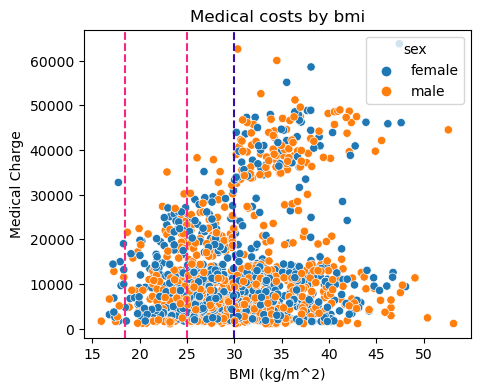

In [14]:
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='bmi', y='charges', hue='sex')
plt.axvline(x=18.5, color='#F72585', linestyle = '--')  # under 18.5 - underweight, between 18.5~24.9 - Normal
plt.axvline(x=25, color = '#F72585', linestyle = '--')  # between 25~29.9 - Overweight
plt.axvline(x=30, color = '#3A0CA3', linestyle = '--')     # Over 30 - Obese
plt.title("Medical costs by bmi")
plt.xlabel("BMI (kg/m^2)")
plt.ylabel("Medical Charge")
plt.show()

In [15]:
# Group by BMI when individual pay more than $30000

bins_bmi = [df['bmi'].min(), 18.5, 25, 30, df['bmi'].max()]
charges_30k = df[df['charges']>30000]
charges_30k['bmi'].value_counts(bins=bins_bmi, sort=False).rename_axis('BMI Group').reset_index(name='Numbers of Individuals')

,BMI Group,Numbers of Individuals
0,"(15.959000000000001, 18.5]",1
1,"(18.5, 25.0]",2
2,"(25.0, 30.0]",10
3,"(30.0, 53.13]",149


In [16]:
# Individuals who have BMI over or equal to 50

df[df['bmi']>=50]

,index,age,sex,bmi,children,smoker,region,charges
846,847,23,male,50.38,1,no,southeast,2438.0552
1046,1047,22,male,52.58,1,yes,southeast,44501.3982
1316,1317,18,male,53.13,0,no,southeast,1163.4627


We have made 3 lines that can clearly see the convenient rule of the BMI, after more discoveries, we have seen the following insights:
* In the group of individuals who pay medical bills more than \\$30000, there is more than \\90% of individuals who are considered as obese.
* But at the same time, not all the individuals who are obese need to pay large bills. There are a large number of obese individuals who pay the medical bills less than \\$15000. Three extreme examples of individuals who have BMI over 50 kg/m^2, the medical bill can be as low as \\$1163 (the individual who has the largest BMI number in the dataset), or as high as \\$44501. Compared to other variables between these three individuals, the biggest difference is, the individual who pays \\$44501 is the smoker.
* But (another but), the extremely high BMI still doesn't mean the individuals will likely pay the most of the medical bills! Look at the scatter plot above, except the largest medical bill owner, the top 5 medical bill owners all have a BMI between 30-40 kg/m^2. That is probably because they have other medical concerns other than the issues that are caused by their body masses.
* Let's not forget the group of underweight, normal and overweight (overweight: between normal and obese), the individuals who are considered as underweight tend to pay the least medical bills than any other groups. When BMI grows, the medical bills are likely to increase too, even though the BMI is considered normal.

### Question: Do smokers pay more than non-smokers?

As we know we all need to select if we are smokers when we apply for insurance. It seems like a concern for all of the insurance companies.

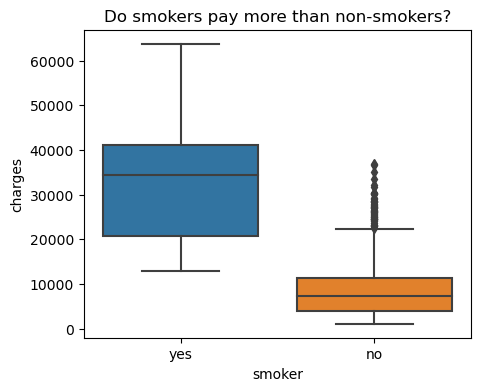

In [17]:
plt.figure(figsize=(5,4))
sns.boxplot(data=df, x='smoker',y='charges')
plt.title("Do smokers pay more than non-smokers?")
plt.show()

This box plot gives us a very clear trend that the smokers are likely to pay more than the non-smokers. But let's discover even more. Let's use the same scatter plot for BMI above, but compare by `smoker` instead of `sex`.

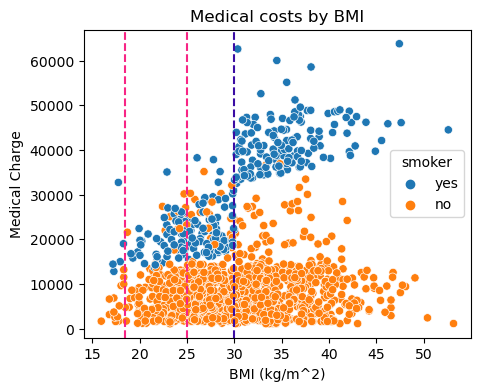

In [18]:
plt.figure(figsize=(5,4))
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')
plt.axvline(x=18.5, color='#F72585', linestyle = '--')  # under 18.5 - underweight, between 18.5~24.9 - Normal
plt.axvline(x=25, color = '#F72585', linestyle = '--')  # between 25~29.9 - Overweight
plt.axvline(x=30, color = '#3A0CA3', linestyle = '--')     # Over 30 - Obese
plt.title("Medical costs by BMI")
plt.xlabel("BMI (kg/m^2)")
plt.ylabel("Medical Charge")
plt.show()

In [19]:
# Find out the minimum medical bills for smokers and non-smokers

df.groupby(['smoker'])['charges'].min()

smoker
no      1121.8739
yes    12829.4551
Name: charges, dtype: float64

* Now we find out why not all the individuals who are obese need to pay large bills. The smoke condition basically separates the medical bills into 2 groups, there are only a few of obese non-smokers who need to pay more than \\$30000. In the other words, when the individuals are overweight, even obese, they will likely pay less in medical bills when they are non-smokers.
* We still see there are about 20 non-smoke individuals who are considered normal in BMI, they pay larger bills than other normal BMI non-smokers, that is probably because they have other medical concerns other than the issues that are caused by their body masses.
* Not even one smoker has a medical bill less than $\\10000 in this dataset, the minimum medical bills for smokers is about \\$12829.
* So we can conclude here, the medical bills tend to increase more for the smokers when the smokers are overweight and obese.

### Question: How much will the medical bill change when the number of children increases?

Note: 
<br>

As the database describes, the `children` variable shows the number of children, AND the dependents. But there is also a chance that spouses are counted as "dependents", but we will not consider this kind of situation in our EDA process. In the other word, we will consider dependents = children in this project.

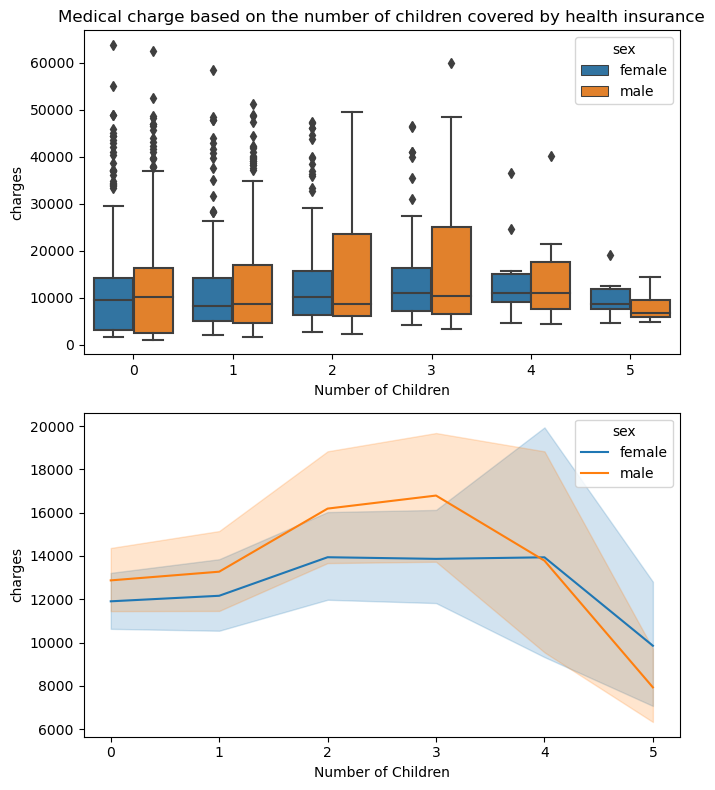

In [20]:
fig, axes = plt.subplots(2, 1, figsize = (7,8))

sns.boxplot(data=df, x='children', y='charges', hue='sex', ax = axes[0])
axes[0].set_title("Medical charge based on the number of children covered by health insurance")
axes[0].set_xlabel("Number of Children")

sns.lineplot(data=df, x='children', y='charges', hue='sex', ax = axes[1])
axes[1].set_xlabel("Number of Children")

plt.tight_layout()
plt.show()

In [21]:
df.groupby(['sex'])['charges'].mean()

sex
female    12569.578844
male      13974.998864
Name: charges, dtype: float64

* As we can see over the figures above, when individuals have 3 children, they tend to have the most average medical bills compared to others. When the individuals have 5 children, they tend to have the least average medical bills compared to others.
* When the individuals who have under and equal to 3 children, the medical bills increase when the number of children increase. When individuals who have more than 3 children, the medical bills drop at a fast pace.
* One interesting thing is, the difference in the medical bill depends on the gender of the applicants. The female applicants who have less than 4 children, tend to have less medical bills than the male applicants when they have or don't have children as dependents. Once the female applicants have equal or more than 4 children, their medical bills start to be more than the male applicants.

### Question: Does region matter for medical bills?

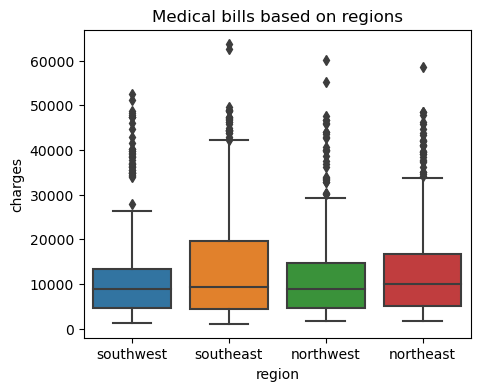

In [22]:
plt.figure(figsize=(5,4))
sns.boxplot(data=df, x='region', y='charges')
plt.title("Medical bills based on regions")
plt.show()

They look very similar to each other, the southeast tends to have a little more medical bills than the other, let's see if we can discover more.

In [23]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64

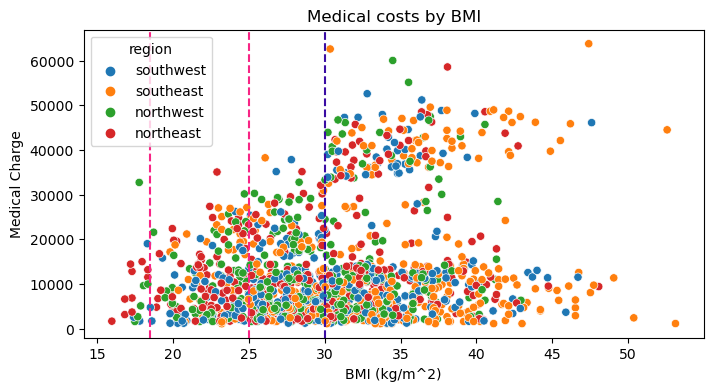

In [24]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='bmi', y='charges', hue='region')
plt.axvline(x=18.5, color='#F72585', linestyle = '--')  # under 18.5 - underweight, between 18.5~24.9 - Normal
plt.axvline(x=25, color = '#F72585', linestyle = '--')  # between 25~29.9 - Overweight
plt.axvline(x=30, color = '#3A0CA3', linestyle = '--')  # Over 30 - Obese
plt.title("Medical costs by BMI")
plt.xlabel("BMI (kg/m^2)")
plt.ylabel("Medical Charge")
plt.show()

In [25]:
# Subset the BMI under 18.5

bmi_under = df[df['bmi']<18.5]
bmi_under.groupby(['region'])['index'].count()

region
northeast    10
northwest     7
southwest     3
Name: index, dtype: int64

In [26]:
# Recall individuals who have BMI over or equal to 50

df[df['bmi']>=50]

,index,age,sex,bmi,children,smoker,region,charges
846,847,23,male,50.38,1,no,southeast,2438.0552
1046,1047,22,male,52.58,1,yes,southeast,44501.3982
1316,1317,18,male,53.13,0,no,southeast,1163.4627


Over the scatterplot we have seen many times but we are now comparing by regions, we can see few more insights:
* The southeast don't have any individuals who are considered as underweight in this dataset, at the same time, the individuals who have BMI over or equal to 50 are all appeared in the group of southwest. Combined with our conclusions shown above: "the individuals who are considered as underweight tend to pay the least medical bills than any other groups. When BMI grows, the medical bills are likely to increase too, even though the BMI is considered normal.", they are one of the reasons that the southwest tends to pay more on medical bills compared to others.

## Construct

Before we construct the machine learning model, we need to convert the categorical variables into dummies.

In [27]:
# recall the info of datset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1337 non-null   int64  
 1   age       1337 non-null   int64  
 2   sex       1337 non-null   object 
 3   bmi       1337 non-null   float64
 4   children  1337 non-null   int64  
 5   smoker    1337 non-null   object 
 6   region    1337 non-null   object 
 7   charges   1337 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.7+ KB


In [28]:
df_model = pd.get_dummies(df, columns = ['sex', 'smoker', 'region'], dtype = "int64")

In [29]:
df_model = df_model.drop(['index', 'sex_female', 'smoker_no'], axis=1)
df_model.rename(columns = {'sex_male':'sex', 'smoker_yes':'smoker'}, inplace = True)  

In [30]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   int64  
 3   charges           1337 non-null   float64
 4   sex               1337 non-null   int64  
 5   smoker            1337 non-null   int64  
 6   region_northeast  1337 non-null   int64  
 7   region_northwest  1337 non-null   int64  
 8   region_southeast  1337 non-null   int64  
 9   region_southwest  1337 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 104.6 KB


Let's have one more plot about the correlations between each variable.

<Axes: >

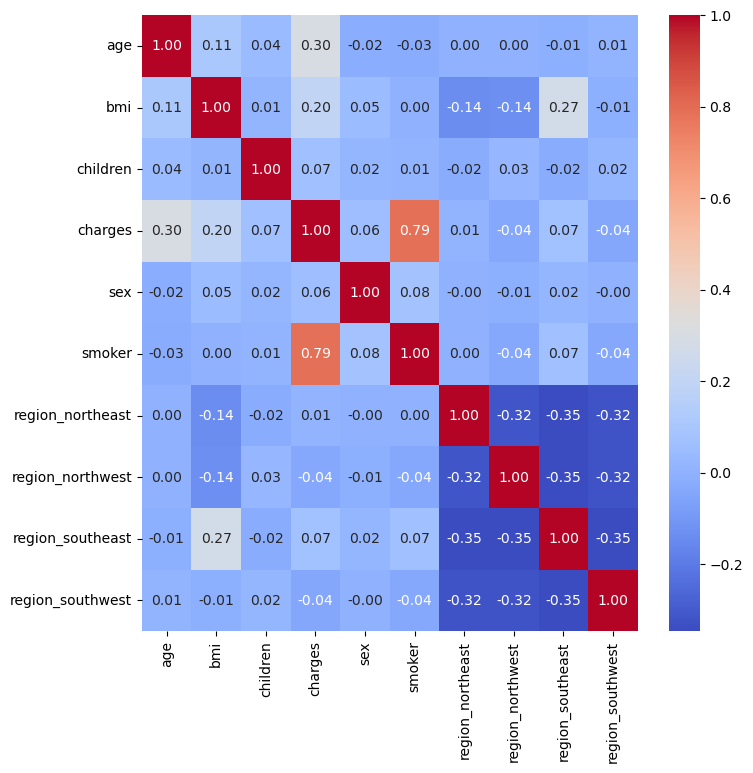

In [31]:
df_corr = df_model.corr()

plt.figure(figsize = (8,8))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm" )

The correlation heatmap proves some of our conclusions above:
1. There is a strong correlation between `charge` and `smoker`.
1. There is also a weak positive correlation between `charge` and `age`, as well as `bmi`.
1. `region_southest` also has a weak positive correlation with `bmi`.

The data types look good, let's subset the variables. As `charges` is our target variable, others are feature variables.

In [32]:
y = df_model['charges']
X = df_model.drop(['charges'], axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state = 42)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1069, 9), (268, 9), (1069,), (268,))

In [35]:
# Perform feature scaling

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

stand_scaler = StandardScaler()
stand_scaler.fit(X_train)
X_train = stand_scaler.transform(X_train)
X_test = stand_scaler.transform(X_test)


#### Basically it is a simple dataset, we would want to run a linear regression, a XGBoost and a LGBM model, then see which model has the best evaluation scores, which are R^2 and MSE.

### Linear Regression

In [36]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_lr = lr.predict(X_test)

In [37]:
print('MSE: %.2f' % mean_squared_error(y_test, y_lr))
print('R^2: %.2f' % r2_score(y_test, y_lr))

MSE: 35478020.68
R^2: 0.81


It is a pretty nice R^2 score, but we still want to try other models.

### XGBoost Regression

In [38]:
xgbr = xgb.XGBRegressor(random_state =0) 

xgbr.fit(X_train, y_train)

y_xgbr = xgbr.predict(X_test)

In [39]:
print('MSE: %.2f' % mean_squared_error(y_test, y_xgbr))
print('R^2: %.2f' % r2_score(y_test, y_xgbr))

MSE: 23830662.24
R^2: 0.87


That's even better!

### LightGBM

In [40]:
lgbm = ltb.LGBMRegressor()
lgbm.fit(X_train, y_train)

y_lgbm = lgbm.predict(X_test)

In [41]:
print('MSE: %.2f' % mean_squared_error(y_test, y_lgbm))
print('R^2: %.2f' % r2_score(y_test, y_lgbm))

MSE: 20631599.59
R^2: 0.89


### Model Conclusion

In [42]:
results = [
    ["Linear Regression", mean_squared_error(y_test, y_lr), r2_score(y_test, y_lr)],
    ["XGBoost", mean_squared_error(y_test, y_xgbr), r2_score(y_test, y_xgbr)],
    ["LGBM",mean_squared_error(y_test, y_lgbm),r2_score(y_test, y_lgbm)]
]
 

head = ["MSE", "R Square"]
 

print(tabulate(results, headers=head, tablefmt="grid"))


+-------------------+-------------+------------+
|                   |         MSE |   R Square |
+===================+=============+============+
| Linear Regression | 3.5478e+07  |   0.806929 |
+-------------------+-------------+------------+
| XGBoost           | 2.38307e+07 |   0.870314 |
+-------------------+-------------+------------+
| LGBM              | 2.06316e+07 |   0.887723 |
+-------------------+-------------+------------+


The LGBM has the best evaluation scores of the three models, so we will keep using it.

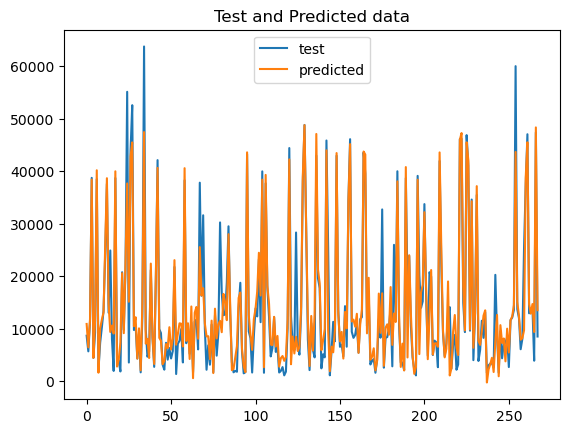

In [43]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="test")
plt.plot(x_ax, y_lgbm, label="predicted")
plt.title("Test and Predicted data")
plt.legend()
plt.show()

The test and predicted set are quite comparable. So, we cannot say there is overfitting.

## Conclusion

1. We have found some insights and trends through our EDA processes, more details have shown above.
1. We built a LightGBM model and had 0.89 R^2 score, that means 89% of the target variance can be explained by the model features.

## Recommendations

1. The medical costs billed by health insurance are based on the policy of government, insurance companies. In the other words, the medical costs can be changed even though with the exact same values in our variables.
1. This dataset only contains ~1300 data, we always prefer more data if we want the model with more accuracy.
1. It will be even better if we can have more feature variables (columns). 
1. The dataset was updated 5 years ago, we can always look for a newer dataset for a better prediction model. 

## Next Step

1. We will specify the parameters into our model. We expect the evaluation scores can be even higher.
1. We are excited to discover more insights through some unsupervised machine learning or even deep learning models. 